This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import Audio
import matplotlib.pyplot as plt
from torch import optim
from torchsummary import summary


# feel free to add more imports here

### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [2]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


Change the `selected_language` to any of the 6 language codes, and re-run the cell below to hear some random clips from the training data.

In [3]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


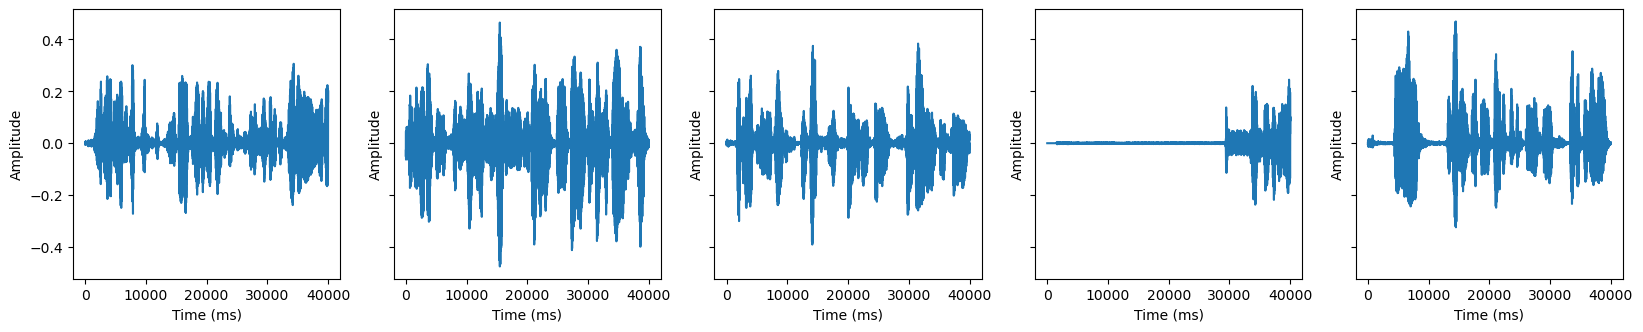

In [4]:
indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey = True)
for ax, audio_index in zip(axes,indexes_random):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [7]:
# normalization with MFCC

from torchaudio import transforms

sample_rate = 40000/5
transform_MFCC = transforms.MFCC(sample_rate = sample_rate)

class MFCC(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        with torch.no_grad():
            x = transform_MFCC(x)
        return x
    
MFCC_transformation = MFCC()

In [ ]:
"""
# transforming the dataset to MFCC

from matplotlib import cm

tensor_X_train = torch.tensor(X_train_sub)
transformed_tensor = MFCC_transformation(tensor_X_train)
transformed_array = np.array(transformed_tensor)


indexes = [100, 200, 300, 400, 500]

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)
time = np.linspace(0, 39999, 40000)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, X_train_sub[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)
for ax, audio_index in zip(axes,indexes):
    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = 'lower')
    ax.set_xlabel('Freq_bins')
    ax.set_ylabel('Coefficients')
    ax.set_title("MFCC")
    """

In [6]:
#Isolating english and spanish for the initial model creation

idxs = np.where((y_train == language_dict['en'])|(y_train == language_dict['es'])) 
idxs_test = np.where((y_test == language_dict['en'])|(y_test == language_dict['es'])) 

y_train_sub = y_train[idxs]
X_train_sub = X_train[idxs]

y_test_sub = y_train[idxs_test]
X_test_sub = X_test[idxs_test]

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


In [10]:
# Create a sequential model - CNN
model = nn.Sequential(MFCC_transformation)

# Add convolutional and pooling layers
#notebook used Conv2d and MaxPool2d 
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2))

model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2))

model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3))
model.add_module('Relu_3', nn.ReLU())

model = model.to(device)

in_shape = X_train_sub.shape
summary(model, input_size=(in_shape))

Layer (type:depth-idx)                   Param #
├─MFCC: 1-1                              --
├─Conv2d: 1-2                            320
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            18,496
├─ReLU: 1-6                              --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            36,928
├─ReLU: 1-9                              --
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─MFCC: 1-1                              --
├─Conv2d: 1-2                            320
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            18,496
├─ReLU: 1-6                              --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            36,928
├─ReLU: 1-9                              --
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0

In [12]:
# RNN (also code from notebooks)
# I have no idea whether this is okay

class Recurrent(nn.Module):
    """
    A class for a recurrent neural network model with an embedding layer,
    a GRU/LSTM/RNN layer, and a linear output layer.

    Args:
        input_dim (int): The size of the input vocabulary.
        hidden_dim (int): The number of units in the hidden layer.
        output_dim (int): The size of the output vocabulary.
        recurrent (nn.GRU/nn.LSTM/nn.RNN): The type of recurrent layer to use.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, recurrent):
        super().__init__()
        self.recurrent = recurrent(input_dim, hidden_dim, num_layers=1)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):

        # RNN and GRU return a tuple of (output, h_n) where output has shape
        # (seq_len, batch, hidden_size)
        # and contains the sequence of activations in the final layer of the RNN
        # and h_n has shape (num_layers, batch, hidden_size)
        # and contains the set of activations at the final step in the sequences
        # for each layer
        # LSTM also returns c_n, the state of the memory cell, so we
        # need to adapt the code here.
        output, h_n = self.recurrent(data)

        if type(self.recurrent) == nn.LSTM:
            last = h_n[0][-1, :, :]
        else:
            last = h_n[-1, :, :]

        # We will apply the linear layer to the activation at the end of the
        # input sequence, for the last recurrent layer
        return self.linear(last)

In [13]:
# please check whether this is correct because idk
# it apparently cannot take a 2d shape as input_dim and output_dim, why?

input_dim = X_train_sub.shape[0]
output_dim = np.zeros((2000, 2)).shape[0] # 2000 instances with 2 different labels (English or Spanish)

model_GRU = Recurrent(input_dim, 8, 32, output_dim, recurrent=nn.GRU).to(device)

summary(model_GRU)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         16,000
├─GRU: 1-2                               4,032
├─Linear: 1-3                            66,000
Total params: 86,032
Trainable params: 86,032
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         16,000
├─GRU: 1-2                               4,032
├─Linear: 1-3                            66,000
Total params: 86,032
Trainable params: 86,032
Non-trainable params: 0

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [ ]:
torch.jit.save(torch.jit.script(model), "model_test.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [ ]:
model = torch.jit.load("model_test.pt")

In [ ]:
model(inputs)

### Making a PCA plot of the output space

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [ ]:
model_outputs = torch.randn(1200, 6)
targets = torch.randint(0, 6, (1200,))

In [ ]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);